In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import os
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

In [5]:
cities_of_interest = [
    "Madrid", "Barcelona", "Paris", "Berlin", "Amsterdam", 
    "Bruxelles", "Lisbon", "Vienna", "Warsaw", 
    "Budapest", "Stockholm", "Helsinki", "Oslo", "London", "Prague", "Dublin", "Zurich", 
    "Munich"
]

In [6]:
url = "https://api.citybik.es/v2/networks"
response = requests.get(url)
if response.status_code == 200:
    networks = response.json().get("networks", [])
    bike_data = []
    extraction_date = datetime.now().strftime("%Y-%m-%d %H:%M")
    for network in networks:
        city = network.get("location", {}).get("city")
        if city in cities_of_interest:
            stations_url = f"https://api.citybik.es/v2/networks/{network['id']}"
            stations_response = requests.get(stations_url)
            if stations_response.status_code == 200:
                stations = stations_response.json().get("network", {}).get("stations", [])
                for station in stations:
                    bike_data.append([
                        network["name"], network["id"], city, network["location"]["country"],
                        station.get("free_bikes", 0), station.get("empty_slots", 0), 
                        station.get("latitude"), station.get("longitude"), extraction_date 
                    ])

In [ ]:
from src.extraccion import extraccion_API ### puedo ponerlo en el main ##
#df = extraccion_API(cities_of_interest)
#df.to_csv("Datos/bici_publicas_oficial_sucio.csv", mode="a", header=not os.path.isfile("bici_publicas_oficial_sucio.csv"), index=False)

In [2]:
#### limpieza / Transformacion #####
df_limpieza = pd.read_csv("Datos/bici_publicas_oficial_sucio.csv")
lista_columnas = df_limpieza.columns.tolist()
df_cleaned = df_limpieza[~df_limpieza.apply(lambda row: row.tolist() == lista_columnas, axis=1)]
df_cleaned.to_csv("Datos/bicis_publicas_sucio1.csv", index=False)

In [3]:
### Renombrar columnas ##
df_rename = pd.read_csv("Datos/bicis_publicas_sucio1.csv")
nuevos_nombres = {
    "name": "empresa",
    "id": "id_empresa",
    "city": "ciudad",
    "country": "pais",
    "free_bikes": "bicis_libres",
    "empty_slots": "anclajes_vacios",
    "extraction_date": "fecha"
}
df_rename.rename(columns=nuevos_nombres, inplace=True)
df_rename["fecha"] = pd.to_datetime(df_rename["fecha"], errors="coerce")
df_rename["anclajes_vacios"] = pd.to_numeric(df_rename["anclajes_vacios"], errors="coerce").fillna(0).astype(int)
df_rename = df_rename[df_rename["anclajes_vacios"] >= 0]


In [7]:
#### columnas calculadas ####
df_rename["capacidad_estacion"] = (df_rename["anclajes_vacios"] + (df_rename["bicis_libres"]))
df_rename["tasa_uso"] = (df_rename["anclajes_vacios"] / (df_rename["capacidad_estacion"]))
df_rename.dropna(subset=["tasa_uso"])
df_rename.to_csv("Datos/bicis_publicas_sucio1.csv", index=False)

In [8]:
#### Crear columna geometry en formato GeoDataFrame ####

df_limpio = pd.read_csv("Datos/bicis_publicas_limpio.csv")
df_limpio["geometry"] = df_limpio.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'Datos/bicis_publicas_limpio.csv'

In [20]:
#### convertir el dataframe en geodataframe ####
gdf_limpio = gpd.GeoDataFrame(df_limpio, geometry="geometry")
gdf_limpio.to_csv("Datos/bicis_publicas_limpio_geodf.csv", index=False)

In [ ]:
df_aire_sucio = pd.read_csv("Datos/dim_aire_sucio.csv")

### eliminar filas ####
ciudades_a_eliminar = ["Amsterdam", "Stockholm", "Zurich", "Munich"]
df_aire_limpio = df_aire_sucio[~df_aire_sucio['Ciudad'].isin(ciudades_a_eliminar)]
df_aire_limpio

In [2]:
df_poblacion_sucio = pd.read_csv("Datos/dim_poblacion_sucio.csv")

# Ciudades a eliminar #
df_poblacion_limpio = df_poblacion_sucio[~df_poblacion_sucio['Ciudad'].isin(ciudades_a_eliminar)]
df_poblacion_limpio

NameError: name 'ciudades_a_eliminar' is not defined

In [2]:
analisis_estad =pd.read_csv("Datos/df_completo.csv")
analisis_estad["fecha"] = pd.to_datetime(analisis_estad["fecha"], errors="coerce")
analisis_estad.info()
analisis_estad.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247905 entries, 0 to 247904
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   empresa             247905 non-null  object        
 1   id_empresa          247905 non-null  object        
 2   Ciudad              247905 non-null  object        
 3   pais                247905 non-null  object        
 4   bicis_libres        247905 non-null  int64         
 5   anclajes_vacios     247905 non-null  int64         
 6   latitude            247905 non-null  float64       
 7   longitude           247905 non-null  float64       
 8   fecha               247905 non-null  datetime64[ns]
 9   capacidad_estacion  247905 non-null  int64         
 10  tasa_uso            235708 non-null  float64       
 11  geometry            247905 non-null  object        
 12  Poblacion           247905 non-null  int64         
dtypes: datetime64[ns](1), float64

,bicis_libres,anclajes_vacios,latitude,longitude,fecha,capacidad_estacion,tasa_uso,Poblacion
count,247905.000000,247905.000000,247905.000000,247905.000000,247905,247905.000000,235708.000000,2.479050e+05
mean,5.162663,8.922115,50.824011,9.224958,2025-03-24 13:15:22.930477312,14.084778,0.692951,3.212022e+06
min,0.000000,0.000000,38.693500,-9.226569,2025-03-17 08:28:00,0.000000,0.000000,1.851030e+05
25%,0.000000,3.000000,48.876201,2.300195,2025-03-20 08:30:00,4.000000,0.500000,2.140526e+06
50%,2.000000,4.000000,52.462719,13.317656,2025-03-25 08:30:00,8.000000,0.756757,3.748148e+06
75%,8.000000,14.000000,52.518536,13.444244,2025-03-28 08:30:00,23.000000,1.000000,3.748148e+06
max,250.000000,68.000000,60.333005,25.159346,2025-04-01 17:30:00,252.000000,1.000000,8.799800e+06
std,7.615760,9.267564,4.785404,8.033289,NaN,12.561742,0.328584,1.991139e+06


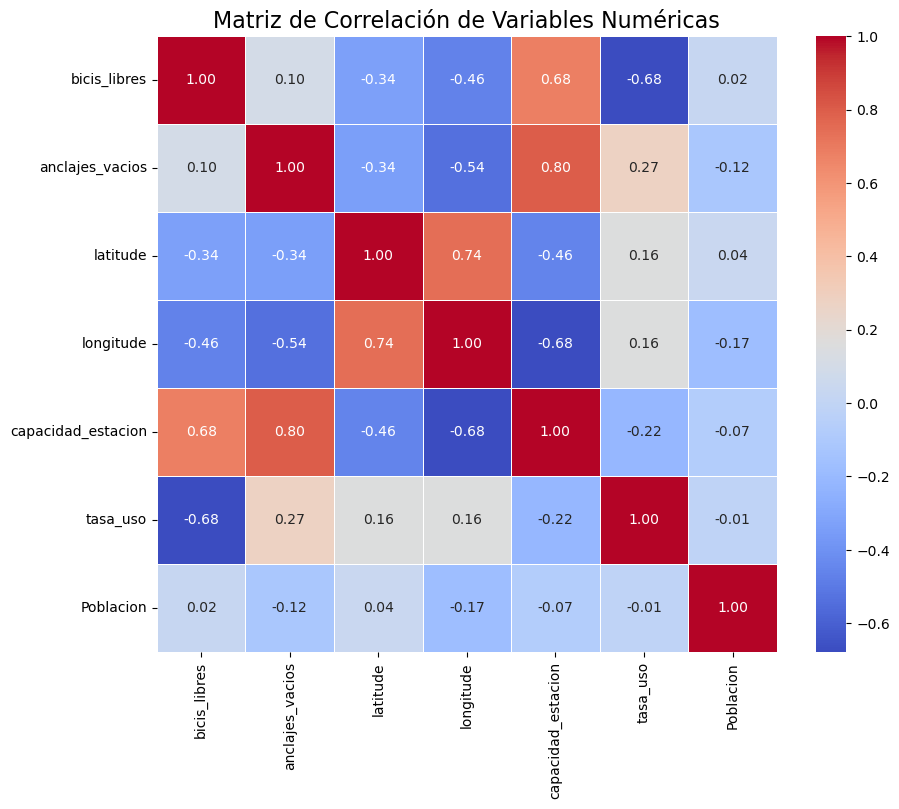

In [3]:
# Seleccionar solo las columnas numéricas del DataFrame
m_corr = analisis_estad.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
matriz_corr = m_corr.corr(method='pearson')

# Crear un mapa de calor para la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16)
plt.show()

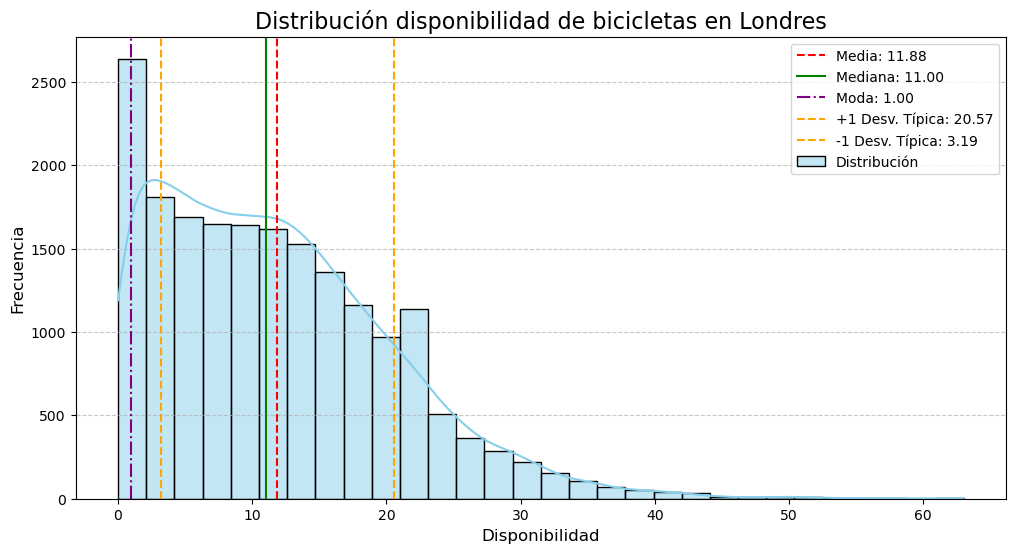

In [4]:
analisis_london = analisis_estad[analisis_estad['Ciudad'] == 'London']



# Calcular estadísticas
media = analisis_london['bicis_libres'].mean()
mediana = analisis_london['bicis_libres'].median()
moda = stats.mode(analisis_london['bicis_libres'], keepdims=True)[0][0]
desviacion_tipica = analisis_london['bicis_libres'].std()

# Crear el gráfico de distribución
plt.figure(figsize=(12, 6))
sns.histplot(analisis_london, x='bicis_libres', kde=True, bins=30, color='skyblue', label='Distribución')

# Dibujar líneas para la media, mediana y desviación típica
plt.axvline(media, color='red', linestyle='--', linewidth=1.5, label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana:.2f}')
plt.axvline(moda, color='purple', linestyle='-.', linewidth=1.5, label=f'Moda: {moda:.2f}')
plt.axvline(media + desviacion_tipica, color='orange', linestyle='--', linewidth=1.5, label=f'+1 Desv. Típica: {media + desviacion_tipica:.2f}')
plt.axvline(media - desviacion_tipica, color='orange', linestyle='--', linewidth=1.5, label=f'-1 Desv. Típica: {media - desviacion_tipica:.2f}')

# Personalizar el gráfico
plt.title('Distribución disponibilidad de bicicletas en Londres', fontsize=16)
plt.xlabel('Disponibilidad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

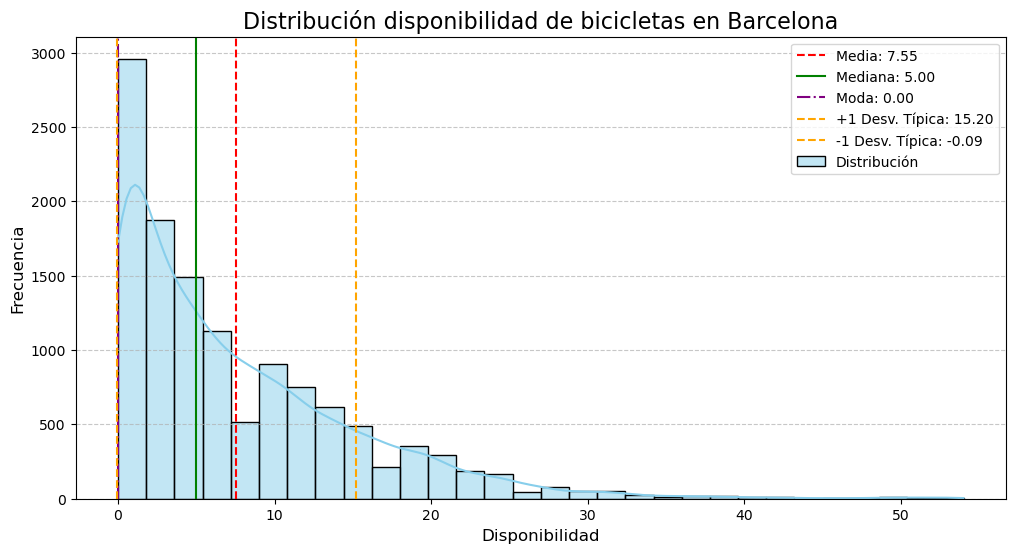

In [5]:
analisis_barcelona = analisis_estad[analisis_estad['Ciudad'] == 'Barcelona']



# Calcular estadísticas
media = analisis_barcelona['bicis_libres'].mean()
mediana = analisis_barcelona['bicis_libres'].median()
moda = stats.mode(analisis_barcelona['bicis_libres'], keepdims=True)[0][0]
desviacion_tipica = analisis_barcelona['bicis_libres'].std()

# Crear el gráfico de distribución
plt.figure(figsize=(12, 6))
sns.histplot(analisis_barcelona, x='bicis_libres', kde=True, bins=30, color='skyblue', label='Distribución')

# Dibujar líneas para la media, mediana y desviación típica
plt.axvline(media, color='red', linestyle='--', linewidth=1.5, label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana:.2f}')
plt.axvline(moda, color='purple', linestyle='-.', linewidth=1.5, label=f'Moda: {moda:.2f}')
plt.axvline(media + desviacion_tipica, color='orange', linestyle='--', linewidth=1.5, label=f'+1 Desv. Típica: {media + desviacion_tipica:.2f}')
plt.axvline(media - desviacion_tipica, color='orange', linestyle='--', linewidth=1.5, label=f'-1 Desv. Típica: {media - desviacion_tipica:.2f}')

# Personalizar el gráfico
plt.title('Distribución disponibilidad de bicicletas en Barcelona', fontsize=16)
plt.xlabel('Disponibilidad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

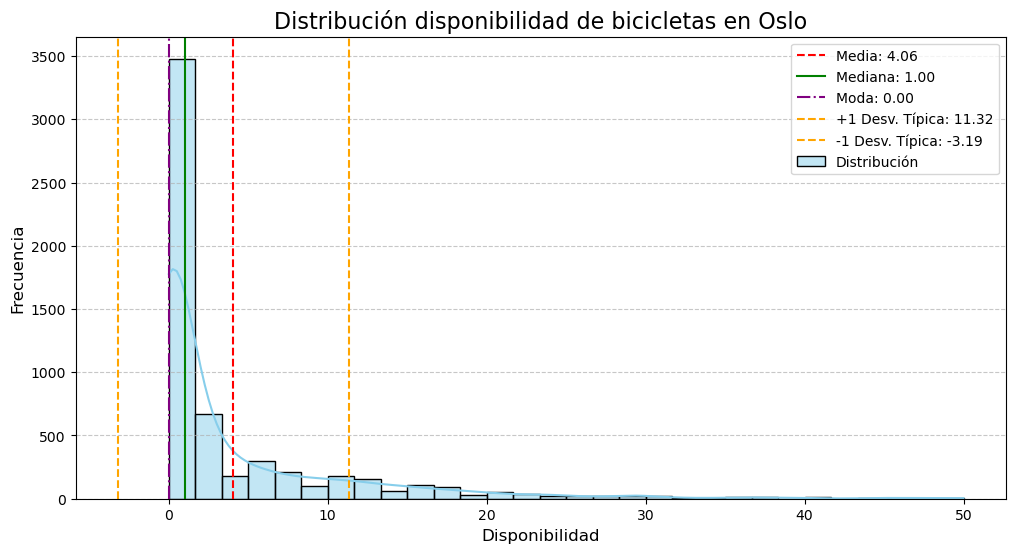

In [6]:
analisis_oslo = analisis_estad[analisis_estad['Ciudad'] == 'Oslo']



# Calcular estadísticas
media = analisis_oslo['bicis_libres'].mean()
mediana = analisis_oslo['bicis_libres'].median()
moda = stats.mode(analisis_oslo['bicis_libres'], keepdims=True)[0][0]
desviacion_tipica = analisis_oslo['bicis_libres'].std()

# Crear el gráfico de distribución
plt.figure(figsize=(12, 6))
sns.histplot(analisis_oslo, x='bicis_libres', kde=True, bins=30, color='skyblue', label='Distribución')

# Dibujar líneas para la media, mediana y desviación típica
plt.axvline(media, color='red', linestyle='--', linewidth=1.5, label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana:.2f}')
plt.axvline(moda, color='purple', linestyle='-.', linewidth=1.5, label=f'Moda: {moda:.2f}')
plt.axvline(media + desviacion_tipica, color='orange', linestyle='--', linewidth=1.5, label=f'+1 Desv. Típica: {media + desviacion_tipica:.2f}')
plt.axvline(media - desviacion_tipica, color='orange', linestyle='--', linewidth=1.5, label=f'-1 Desv. Típica: {media - desviacion_tipica:.2f}')

# Personalizar el gráfico
plt.title('Distribución disponibilidad de bicicletas en Oslo', fontsize=16)
plt.xlabel('Disponibilidad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
#### Contraste de hipótesis ####

# Filtrar los datos para la ciudad de Madrid
df_madrid = analisis_estad[analisis_estad['Ciudad'] == 'Madrid']

# Verificar si hay valores nulos en las columnas relevantes
df_madrid = df_madrid.dropna(subset=['bicis_libres', 'tasa_uso'])

# Calcular la correlación entre el número de bicicletas libres y la tasa de uso
correlacion, p_valor = stats.pearsonr(df_madrid['bicis_libres'], df_madrid['tasa_uso'])

# Mostrar los resultados
print(f"Coeficiente de correlación de Pearson: {correlacion:.2f}")
print(f"Valor p: {p_valor:.4f}")

# Interpretación del valor p
if p_valor < 0.05:
    print("Rechazamos la hipótesis nula: El número de bicicletas libres en Madrid influye en la tasa de uso.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que el número de bicicletas libres en Madrid influye en la tasa de uso.")



Coeficiente de correlación de Pearson: -0.97
Valor p: 0.0000
Rechazamos la hipótesis nula: El número de bicicletas libres en Madrid influye en la tasa de uso.


                            OLS Regression Results                            
Dep. Variable:           bicis_libres   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 2.554e+05
Date:               ju., 03 abr. 2025   Prob (F-statistic):               0.00
Time:                        20:00:30   Log-Likelihood:                -26780.
No. Observations:               15020   AIC:                         5.356e+04
Df Residuals:                   15018   BIC:                         5.358e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.2293      0.029    847.286      0.0

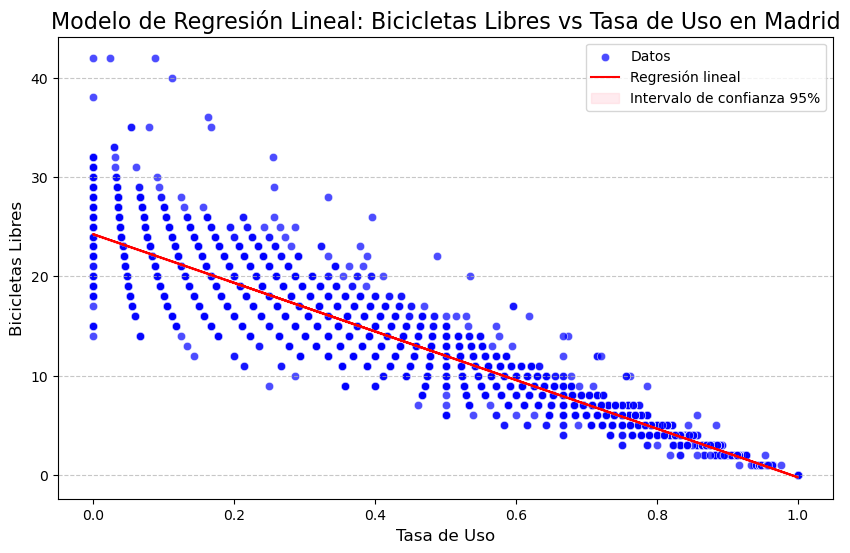

In [8]:


X = df_madrid['tasa_uso']
Y = df_madrid['bicis_libres']


X = sm.add_constant(X)

# Crear el modelo de regresión lineal
modelo = sm.OLS(Y, X).fit()

# Resumen del modelo
print(modelo.summary())

# Visualizar la relación con un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tasa_uso', y='bicis_libres', data=df_madrid, color='blue', alpha=0.7, label='Datos')
plt.plot(df_madrid['tasa_uso'], modelo.predict(X), color='red', label='Regresión lineal')

# Calcular el intervalo de confianza para la predicción
predicciones = modelo.get_prediction(X)
pred_summary = predicciones.summary_frame(alpha=0.05)  # Intervalo de confianza al 95%

# Dibujar el intervalo de confianza
plt.fill_between(df_madrid['tasa_uso'], 
                 pred_summary['mean_ci_lower'], 
                 pred_summary['mean_ci_upper'], 
                 color='pink', alpha=0.3, label='Intervalo de confianza 95%')

# Personalizar el gráfico
plt.title('Modelo de Regresión Lineal: Bicicletas Libres vs Tasa de Uso en Madrid', fontsize=16)
plt.xlabel('Tasa de Uso', fontsize=12)
plt.ylabel('Bicicletas Libres', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [2]:
geodataframe = gpd.read_file("Datos/bicis_publicas_limpio_geodf_p.csv")
geodataframe = geodataframe.drop(columns=["geometry"])
# Crear la columna 'geometry' a partir de 'latitude' y 'longitude'
geodataframe['geometry'] = geodataframe.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convertir el DataFrame en un GeoDataFrame
geodataframe = gpd.GeoDataFrame(geodataframe, geometry='geometry')

# Asignar un sistema de referencia de coordenadas (CRS)
# Usualmente, las coordenadas de latitud y longitud están en WGS 84 (EPSG:4326)
geodataframe.set_crs(epsg=4326, inplace=True)
# Filtrar los datos para la ciudad de París
paris_data = geodataframe[geodataframe['Ciudad'] == 'Paris']
# Extraer latitud y longitud de la columna 'geometry'
paris_data['lat'] = paris_data.geometry.y
paris_data['lon'] = paris_data.geometry.x
paris_data['lat'] = pd.to_numeric(paris_data['lat'], errors='coerce')
paris_data['lon'] = pd.to_numeric(paris_data['lon'], errors='coerce')
paris_data['tasa_uso'] = pd.to_numeric(paris_data['tasa_uso'], errors='coerce')
paris_data = paris_data.dropna(subset=['lat', 'lon', 'tasa_uso'])
mapa_paris = folium.Map(location=[paris_data['lat'].mean(), paris_data['lon'].mean()], zoom_start=12)

# Preparar los datos para el mapa de calor
heat_data = paris_data[['lat', 'lon', 'tasa_uso']].values.tolist()

# Agregar el mapa de calor
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(mapa_paris)

# Mostrar el mapa
mapa_paris

c:\Users\pablo\miniconda3\envs\proyecto_bicicletas\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\pablo\miniconda3\envs\proyecto_bicicletas\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
